#**S25 - Evidencia de Aprendizaje 1**

##INSTALACIONES Y CONFIGURACI√ìN INICIAL

In [ ]:
# Instala las librer√≠as necesarias KaggleHub y ydata-profiling
# --upgrade --quiet asegura que se actualicen y no muestren la salida detallada
!pip install kagglehub[pandas-datasets] ydata-profiling --upgrade --quiet

# Importa la librer√≠a pandas para manipulaci√≥n de datos
import pandas as pd
# Importa kagglehub para cargar datasets de Kaggle
import kagglehub
# Importa KaggleDatasetAdapter para especificar el tipo de adaptador (Pandas en este caso)
from kagglehub import KaggleDatasetAdapter
# Importa ProfileReport de ydata-profiling para generar reportes exploratorios
from ydata_profiling import ProfileReport
# Importa numpy para operaciones num√©ricas (aunque no se usa directamente en esta celda, es una importaci√≥n com√∫n)
import numpy as np
# Importa display para mostrar DataFrames de forma m√°s amigable en Colab
from IPython.display import display
# Importa warnings para manejar advertencias
import warnings
# Ignora las advertencias para no saturar la salida
warnings.filterwarnings('ignore')

# Configura pandas para mostrar todas las columnas de un DataFrame
pd.set_option('display.max_columns', None)
# Configura pandas para mostrar n√∫meros flotantes con 2 decimales
pd.set_option('display.precision', 2)

## CARGA Y OPTIMIZACI√ìN DE DATOS

In [ ]:
import time

def load_dataset_fast(file_path="2019-Oct.csv", sample_size=500000):
    """Carga dataset de forma ultra-r√°pida con optimizaciones autom√°ticas y muestreo."""

    # Tipos optimizados - using the most efficient ones
    dtype_dict = {
        'event_type': 'category',
        'product_id': 'int32',
        'category_id': 'int64',
        'category_code': 'category',
        'brand': 'category',
        'price': 'float32',
        'user_id': 'int32',
        'user_session': 'category'
    }

    print(f"Cargando: {file_path}")
    start_time = time.time()

    try:
        # OPTIMIZACI√ìN 1: Cargar con tipos desde el inicio
        # kagglehub.load_dataset does not have a dtype parameter, removing it.
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "mkechinov/ecommerce-behavior-data-from-multi-category-store",
            file_path,
            # dtype=dtype_dict # Removed as it's not supported
        )
        print("Cargado con tipos optimizados")

    except:
        # OPTIMIZACI√ìN 2: Carga r√°pida + conversi√≥n eficiente
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "mkechinov/ecommerce-behavior-data-from-multi-category-store",
            file_path
        )

        # Conversi√≥n r√°pida por lotes
        print("Optimizando tipos...")

        # Convertir categ√≥ricas (m√°s r√°pido en lote)
        categorical_cols = ['event_type', 'category_code', 'brand', 'user_session']
        for col in categorical_cols:
            if col in df.columns:
                df[col] = df[col].astype('category')

        # Convertir num√©ricos (downcast autom√°tico)
        numeric_cols = {'product_id': 'int32', 'user_id': 'int32', 'price': 'float32'}
        for col, dtype in numeric_cols.items():
            if col in df.columns:
                # Removed downcast argument as it was causing the error
                df[col] = pd.to_numeric(df[col], errors='ignore')
                # Convert to specific dtype after to_numeric
                df[col] = df[col].astype(dtype)

    # OPTIMIZACI√ìN 3: Muestreo si el dataset es m√°s grande que el sample_size
    if len(df) > sample_size:
        print(f"Dataset grande ({len(df):,} filas), tomando muestra de {sample_size:,}")
        # Muestreo estratificado por 'event_type' si es posible
        if 'event_type' in df.columns and df['event_type'].nunique() > 1:
             df = df.groupby('event_type', group_keys=False).apply(
                lambda x: x.sample(n=min(len(x), sample_size // df['event_type'].nunique()), random_state=42)
            ).reset_index(drop=True)
        else:
            df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    else:
        print(f"Dataset peque√±o ({len(df):,} filas), usando dataset completo")


    # OPTIMIZACI√ìN 4: Stats r√°pidos
    elapsed = time.time() - start_time
    memory_mb = df.memory_usage(deep=True).sum() / 1024**2

    print(f" Dataset cargado y muestreado en {elapsed:.1f}s:")
    print(f"  ‚Ä¢ Filas: {len(df):,}")
    print(f"  ‚Ä¢ Columnas: {len(df.columns)}")
    print(f"  ‚Ä¢ Memoria: {memory_mb:.1f} MB")

    return df

# Uso ultra-simple con sample_size=500000:
df = load_dataset_fast(sample_size=500000)

Cargando: 2019-Oct.csv
Cargado con tipos optimizados
Dataset grande (42,448,764 filas), tomando muestra de 500,000
 Dataset cargado y muestreado en 180.5s:
  ‚Ä¢ Filas: 499,998
  ‚Ä¢ Columnas: 9
  ‚Ä¢ Memoria: 189.1 MB


## AN√ÅLISIS EXPLORATORIO B√ÅSICO

In [ ]:
# Muestra las primeras 5 filas del DataFrame para una vista previa
display(df.head())

# Muestra informaci√≥n sobre el DataFrame, incluyendo tipos de datos, valores no nulos y uso de memoria (calculado profundamente)
df.info(memory_usage='deep')

# Muestra estad√≠sticas descriptivas del DataFrame.
# include='all' asegura que se incluyan estad√≠sticas para columnas num√©ricas y categ√≥ricas.
display(df.describe(include='all'))

event_time event_type  product_id          category_id  \
0  2019-10-04 09:55:58 UTC       cart     1004741  2053013555631882655   
1  2019-10-26 11:17:32 UTC       cart     5100562  2053013553341792533   
2  2019-10-29 09:14:58 UTC       cart     1004863  2053013555631882655   
3  2019-10-24 05:00:37 UTC       cart     1005100  2053013555631882655   
4  2019-10-17 08:46:22 UTC       cart     1004858  2053013555631882655   

            category_code    brand   price    user_id  \
0  electronics.smartphone   xiaomi  185.67  512856885   
1      electronics.clocks    apple  301.36  513130812   
2  electronics.smartphone  samsung  170.15  565340594   
3  electronics.smartphone  samsung  141.32  512750861   
4  electronics.smartphone  samsung  131.62  561136578   

                           user_session  
0  85a2394c-be15-4bc3-9027-0d486762e470  
1  5dbde477-b293-4ab0-aeea-d721791aa0bf  
2  5b9591ab-2f6d-4aaf-bbe1-85de83ac641f  
3  9f5ca722-82d8-46dd-8f45-24316aff2c82  
4  d0ebb3eb-6323-4138-b812-38567d4a36c7

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499998 entries, 0 to 499997
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     499998 non-null  object 
 1   event_type     499998 non-null  object 
 2   product_id     499998 non-null  int64  
 3   category_id    499998 non-null  int64  
 4   category_code  387594 non-null  object 
 5   brand          458817 non-null  object 
 6   price          499998 non-null  float64
 7   user_id        499998 non-null  int64  
 8   user_session   499998 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 189.1 MB


event_time event_type  product_id  category_id  \
count                    499998     499998    5.00e+05     5.00e+05   
unique                   441485          3         NaN          NaN   
top     2019-10-26 11:45:01 UTC       cart         NaN          NaN   
freq                         12     166666         NaN          NaN   
mean                        NaN        NaN    6.85e+06     2.06e+18   
std                         NaN        NaN    9.61e+06     1.52e+16   
min                         NaN        NaN    1.00e+06     2.05e+18   
25%                         NaN        NaN    1.00e+06     2.05e+18   
50%                         NaN        NaN    1.80e+06     2.05e+18   
75%                         NaN        NaN    8.80e+06     2.05e+18   
max                         NaN        NaN    6.05e+07     2.18e+18   

                 category_code    brand      price   user_id  \
count                   387594   458817  499998.00  5.00e+05   
unique                     124     2188        NaN       NaN   
top     electronics.smartphone  samsung        NaN       NaN   
freq                    218042   112848        NaN       NaN   
mean                       NaN      NaN     310.30  5.35e+08   
std                        NaN      NaN     353.73  1.84e+07   
min                        NaN      NaN       0.00  2.84e+08   
25%                        NaN      NaN      88.81  5.16e+08   
50%                        NaN      NaN     179.93  5.33e+08   
75%                        NaN      NaN     373.98  5.53e+08   
max                        NaN      NaN    2574.07  5.66e+08   

                                user_session  
count                                 499998  
unique                                437668  
top     1978995d-aa3c-47c4-94bb-1e1eea9c9457  
freq                                      30  
mean                                     NaN  
std                                      NaN  
min                                      NaN  
25%                                      NaN  
50%                                      NaN  
75%                                      NaN  
max                                      NaN

## AN√ÅLISIS DE VALORES √öNICOS Y NULOS

In [ ]:
# Inicializa un diccionario para almacenar el conteo de valores √∫nicos por columna
unique_counts = {}
# Itera sobre cada columna del DataFrame
for col in df.columns:
    # Calcula el n√∫mero de valores √∫nicos para la columna actual y lo almacena en el diccionario
    unique_counts[col] = df[col].nunique()
    # Imprime el nombre de la columna y el n√∫mero de valores √∫nicos, formateado con comas
    print(f"   ‚Ä¢ {col}: {unique_counts[col]:,} valores √∫nicos")

# Calcula el n√∫mero de valores nulos para cada columna
null_counts = df.isnull().sum()
# Comprueba si hay alguna columna con valores nulos (si la suma de nulos es mayor que 0)
if null_counts.sum() > 0:
    # Si hay nulos, imprime un encabezado
    print("Columnas con valores nulos:")
    # Itera sobre las columnas que tienen valores nulos (donde el conteo es mayor que 0)
    for col, count in null_counts[null_counts > 0].items():
        # Imprime el nombre de la columna, el n√∫mero de valores nulos y su porcentaje respecto al total de filas
        print(f"‚Ä¢ {col}: {count:,} ({count/len(df)*100:.2f}%)")
# Si no hay valores nulos en ninguna columna
else:
    # Imprime un mensaje indicando que no hay valores nulos
    print("No hay valores nulos en el dataset")

   ‚Ä¢ event_time: 441,485 valores √∫nicos
   ‚Ä¢ event_type: 3 valores √∫nicos
   ‚Ä¢ product_id: 45,106 valores √∫nicos
   ‚Ä¢ category_id: 588 valores √∫nicos
   ‚Ä¢ category_code: 124 valores √∫nicos
   ‚Ä¢ brand: 2,188 valores √∫nicos
   ‚Ä¢ price: 25,316 valores √∫nicos
   ‚Ä¢ user_id: 317,820 valores √∫nicos
   ‚Ä¢ user_session: 437,668 valores √∫nicos
Columnas con valores nulos:
‚Ä¢ category_code: 112,404 (22.48%)
‚Ä¢ brand: 41,181 (8.24%)


## AN√ÅLISIS ESPEC√çFICO E-COMMERCE

In [ ]:
# Calcula la distribuci√≥n de los tipos de eventos y la imprime
event_dist = df['event_type'].value_counts()
print(event_dist)
# Imprime un encabezado para los porcentajes
print(f"\nPorcentajes:")
# Itera sobre la distribuci√≥n de eventos y calcula e imprime el porcentaje de cada tipo de evento
for event, count in event_dist.items():
    print(f"   ‚Ä¢ {event}: {count/len(df)*100:.2f}%")

# Calcula los 10 productos m√°s frecuentes (por conteo) y los imprime
top_products = df['product_id'].value_counts().head(10)
print(top_products)

# Calcula las 10 marcas m√°s frecuentes (por conteo) y las imprime
top_brands = df['brand'].value_counts().head(10)
print(top_brands)

# Calcula estad√≠sticas descriptivas para la columna 'price' y las imprime
price_stats = df['price'].describe()
print(price_stats)

# Itera sobre los valores √∫nicos en la columna 'event_type'
for event_type in df['event_type'].unique():
    # Filtra el DataFrame para obtener solo las filas del tipo de evento actual
    event_prices = df[df['event_type'] == event_type]['price']
    # Imprime el tipo de evento
    print(f"\n{event_type}:")
    # Calcula e imprime el precio promedio para este tipo de evento
    print(f"‚Ä¢ Promedio: ${event_prices.mean():.2f}")
    # Calcula e imprime la mediana del precio para este tipo de evento
    print(f"‚Ä¢ Mediana: ${event_prices.median():.2f}")
    # Calcula e imprime el precio m√°ximo para este tipo de evento
    print(f"‚Ä¢ M√°ximo: ${event_prices.max():.2f}")

event_type
cart        166666
purchase    166666
view        166666
Name: count, dtype: int64

Porcentajes:
   ‚Ä¢ cart: 33.33%
   ‚Ä¢ purchase: 33.33%
   ‚Ä¢ view: 33.33%
product_id
1004856    17600
1004767    13034
1004833     7611
4804056     7565
1005115     6855
1004870     6610
1002544     5945
5100816     5634
1004249     5482
1004836     4844
Name: count, dtype: int64
brand
samsung    112848
apple       84834
xiaomi      43403
huawei      17142
oppo         8087
lg           6758
lucente      5290
sony         5042
acer         4963
bosch        4750
Name: count, dtype: int64
count    499998.00
mean        310.30
std         353.73
min           0.00
25%          88.81
50%         179.93
75%         373.98
max        2574.07
Name: price, dtype: float64

cart:
‚Ä¢ Promedio: $333.69
‚Ä¢ Mediana: $196.94
‚Ä¢ M√°ximo: $2574.04

purchase:
‚Ä¢ Promedio: $308.55
‚Ä¢ Mediana: $179.28
‚Ä¢ M√°ximo: $2574.04

view:
‚Ä¢ Promedio: $288.66
‚Ä¢ Mediana: $161.14
‚Ä¢ M√°ximo: $2574.07


## PREPARACI√ìN DE MUESTRA PARA REPORTE

In [ ]:
# Obtiene el n√∫mero total de filas en el DataFrame
total_rows = len(df)
# Define un tama√±o de muestra si el dataset es grande
if total_rows > 100000:
    sample_size = 50000 # Tama√±o de muestra para datasets muy grandes
    print(f"Dataset grande ({total_rows:,} filas), usando muestra de {sample_size:,}")
# Define un tama√±o de muestra si el dataset es mediano
elif total_rows > 50000:
    sample_size = 25000 # Tama√±o de muestra para datasets medianos
    print(f"Dataset mediano ({total_rows:,} filas), usando muestra de {sample_size:,}")
# Si el dataset es peque√±o, usa el dataset completo como muestra
else:
    sample_size = total_rows # Usa el total de filas si es peque√±o
    print(f"Dataset peque√±o ({total_rows:,} filas), usando dataset completo")

# Si el tama√±o de la muestra es menor que el total de filas (es decir, si se necesita muestreo)
if sample_size < total_rows:
    # Crea una muestra estratificada por tipo de evento.
    # Agrupa el DataFrame por 'event_type'.
    # Aplica una funci√≥n lambda a cada grupo para tomar una muestra.
    # El tama√±o de la muestra para cada grupo es el m√≠nimo entre el tama√±o del grupo y el tama√±o total de la muestra dividido por el n√∫mero de tipos de eventos √∫nicos.
    # random_state=42 asegura reproducibilidad.
    # reset_index(drop=True) reinicia el √≠ndice y elimina la columna de √≠ndice original.
    df_muestra = df.groupby('event_type', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), sample_size//len(df['event_type'].unique())),
                          random_state=42)
    ).reset_index(drop=True)
# Si no se necesita muestreo (dataset peque√±o), la muestra es una copia del DataFrame original
else:
    df_muestra = df.copy()

Dataset grande (499,998 filas), usando muestra de 50,000


## GENERACI√ìN DE REPORTE YDATA-PROFILING

In [ ]:
# Define un diccionario de configuraci√≥n para el reporte de ydata-profiling.
# 'minimal': True genera un reporte m√°s r√°pido y b√°sico.
# 'interactions': {'continuous': False} desactiva el an√°lisis de interacciones entre variables continuas.
# 'correlations': {'auto': {'calculate': False}} desactiva el c√°lculo de correlaciones.
# 'missing_diagrams': desactiva los diagramas de valores faltantes.
# 'duplicates': {'head': 0} desactiva la visualizaci√≥n de filas duplicadas.
# 'samples': {'head': 5, 'tail': 5} muestra las primeras y √∫ltimas 5 filas como ejemplo.
config = {
    'minimal': True,
    'interactions': {'continuous': False},
    'correlations': {'auto': {'calculate': False}},
    'missing_diagrams': {'bar': False, 'matrix': False, 'heatmap': False},
    'duplicates': {'head': 0},
    'samples': {'head': 5, 'tail': 5}
}

# Crea una instancia de ProfileReport utilizando el DataFrame de muestra y la configuraci√≥n definida.
reporte = ProfileReport(
    df_muestra, # DataFrame a analizar
    title="E-commerce Behavior Data Analysis", # T√≠tulo del reporte
    config_file=None, # No usa un archivo de configuraci√≥n externo
    **config # Desempaqueta el diccionario de configuraci√≥n como argumentos
)

# Define el nombre del archivo de salida para el reporte HTML
output_file = 'reporte_ecommerce_segmentado.html'
# Imprime un mensaje indicando d√≥nde se guardar√° el reporte
print(f"Guardando reporte como: {output_file}")
# Guarda el reporte en un archivo HTML
reporte.to_file(output_file)

Guardando reporte como: reporte_ecommerce_segmentado.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:03<00:00,  2.69it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## RESUMEN FINAL Y CONCLUSIONES

In [ ]:
# Imprime un resumen del dataset, incluyendo el n√∫mero total de filas y columnas
print(f"Dataset: {total_rows:,} filas √ó {df.shape[1]} columnas")
# Imprime el rango de fechas cubierto por el dataset (desde el evento m√°s antiguo hasta el m√°s reciente)
print(f"Per√≠odo: {df['event_time'].min()} a {df['event_time'].max()}")
# Imprime el n√∫mero de usuarios √∫nicos en el dataset
print(f"Usuarios √∫nicos: {df['user_id'].nunique():,}")
# Imprime el n√∫mero de productos √∫nicos en el dataset
print(f"Productos √∫nicos: {df['product_id'].nunique():,}")
# Imprime el n√∫mero de marcas √∫nicas en el dataset
print(f"Marcas √∫nicas: {df['brand'].nunique():,}")
# Imprime el n√∫mero de sesiones √∫nicas en el dataset
print(f"Sesiones √∫nicas: {df['user_session'].nunique():,}")

# Imprime un encabezado para el conteo de eventos por tipo
print(f"\nEventos por tipo:")
# Itera sobre la distribuci√≥n de los tipos de eventos y los imprime con su conteo y porcentaje
for event, count in df['event_type'].value_counts().items():
    print(f"   ‚Ä¢ {event}: {count:,} ({count/len(df)*100:.1f}%)")

# Imprime el valor promedio de los productos (basado en la columna 'price')
print(f"\nValor promedio de productos: ${df['price'].mean():.2f}")
# Imprime el rango de precios (m√≠nimo y m√°ximo)
print(f"Rango de precios: ${df['price'].min():.2f} - ${df['price'].max():.2f}")

# Imprime la ruta donde se guard√≥ el reporte detallado
print(f"Reporte detallado disponible en: {output_file}")

Dataset: 499,998 filas √ó 9 columnas
Per√≠odo: 2019-10-01 00:01:07 UTC a 2019-10-31 23:59:21 UTC
Usuarios √∫nicos: 317,820
Productos √∫nicos: 45,106
Marcas √∫nicas: 2,188
Sesiones √∫nicas: 437,668

Eventos por tipo:
   ‚Ä¢ cart: 166,666 (33.3%)
   ‚Ä¢ purchase: 166,666 (33.3%)
   ‚Ä¢ view: 166,666 (33.3%)

Valor promedio de productos: $310.30
Rango de precios: $0.00 - $2574.07
Reporte detallado disponible en: reporte_ecommerce_segmentado.html


## FUNCIONES ADICIONAL PARA AN√ÅLISIS

In [ ]:
# Define una funci√≥n para analizar la actividad de un usuario espec√≠fico
def analizar_usuario_especifico(user_id):
    # Filtra el DataFrame para obtener solo los datos del usuario especificado
    user_data = df[df['user_id'] == user_id]
    # Si no se encuentra el usuario (el DataFrame filtrado est√° vac√≠o)
    if len(user_data) == 0:
        # Imprime un mensaje indicando que el usuario no fue encontrado
        print(f"Usuario {user_id} no encontrado")
        # Sale de la funci√≥n
        return

    # Imprime un encabezado para el an√°lisis del usuario
    print(f"\n--- AN√ÅLISIS USUARIO {user_id} ---")
    # Imprime el n√∫mero total de eventos registrados para este usuario
    print(f"Total de eventos: {len(user_data)}")
    # Imprime un encabezado para los eventos por tipo
    print(f"Eventos por tipo:")
    # Imprime el conteo de cada tipo de evento para este usuario
    print(user_data['event_type'].value_counts())
    # Imprime el n√∫mero de productos √∫nicos que el usuario vio
    print(f"Productos √∫nicos vistos: {user_data['product_id'].nunique()}")
    # Calcula e imprime el gasto total estimado del usuario (suma de precios de eventos de compra, aunque no se especifica el tipo de evento aqu√≠, se asume un an√°lisis general)
    print(f"Gasto total: ${user_data['price'].sum():.2f}")
    # Imprime un encabezado para las marcas favoritas
    print(f"Marcas favoritas:")
    # Imprime las 5 marcas m√°s frecuentes interactuadas por el usuario
    print(user_data['brand'].value_counts().head(5))

# Define una funci√≥n para analizar la actividad relacionada con un producto espec√≠fico
def analizar_producto_especifico(product_id):
    # Filtra el DataFrame para obtener solo los datos relacionados con el producto especificado
    product_data = df[df['product_id'] == product_id]
    # Si no se encuentra el producto (el DataFrame filtrado est√° vac√≠o)
    if len(product_data) == 0:
        # Imprime un mensaje indicando que el producto no fue encontrado
        print(f"Producto {product_id} no encontrado")
        # Sale de la funci√≥n
        return

    # Imprime un encabezado para el an√°lisis del producto
    print(f"\n--- AN√ÅLISIS PRODUCTO {product_id} ---")
    # Imprime el n√∫mero total de interacciones registradas para este producto
    print(f"Total de interacciones: {len(product_data)}")
    # Imprime el n√∫mero de usuarios √∫nicos que interactuaron con este producto
    print(f"Usuarios √∫nicos: {product_data['user_id'].nunique()}")
    # Imprime el precio del producto (toma el precio de la primera fila encontrada)
    print(f"Precio: ${product_data['price'].iloc[0]:.2f}")
    # Imprime la marca del producto (toma la marca de la primera fila encontrada)
    print(f"Marca: {product_data['brand'].iloc[0]}")
    # Imprime la categor√≠a del producto (toma la categor√≠a de la primera fila encontrada)
    print(f"Categor√≠a: {product_data['category_code'].iloc[0]}")
    # Imprime un encabezado para los eventos por tipo relacionados con el producto
    print(f"Eventos por tipo:")
    # Imprime el conteo de cada tipo de evento para este producto
    print(product_data['event_type'].value_counts())

# **S20 - Evidencia de aprendizaje 2**

## ELIMINACI√ìN DE DUPLICADOS


In [ ]:
# Almacena el n√∫mero inicial de filas en el DataFrame
initial_rows = len(df)
# Elimina las filas duplicadas del DataFrame in-place (modifica el DataFrame directamente)
df.drop_duplicates(inplace=True)
# Almacena el n√∫mero final de filas despu√©s de eliminar duplicados
final_rows = len(df)
# Calcula el n√∫mero de duplicados que fueron eliminados
duplicates_removed = initial_rows - final_rows

# Imprime el n√∫mero inicial de filas
print(f"Filas iniciales: {initial_rows:,}")
# Imprime el n√∫mero final de filas
print(f"Filas finales: {final_rows:,}")
# Imprime el n√∫mero de duplicados eliminados
print(f"Duplicados eliminados: {duplicates_removed:,}")
# Imprime un mensaje indicando si se eliminaron duplicados o no
print(f"¬°Dataset limpio!" if duplicates_removed > 0 else "No hab√≠a duplicados.")

Filas iniciales: 499,998
Filas finales: 498,386
Duplicados eliminados: 1,612
¬°Dataset limpio!


## TRATAMIENTO DE VALORES NULOS

In [ ]:
# Calcula el n√∫mero de valores nulos por columna antes del tratamiento
null_counts_before = df.isnull().sum()
# Obtiene una lista de los nombres de las columnas que tienen valores nulos
cols_with_nulls = null_counts_before[null_counts_before > 0].index.tolist()

# Verifica si hay columnas con valores nulos
if cols_with_nulls:
    # Imprime un encabezado indicando las columnas con nulos antes del tratamiento
    print("Columnas con valores nulos antes del tratamiento:")
    # Itera sobre las columnas con nulos
    for col in cols_with_nulls:
        # Obtiene el conteo de nulos para la columna actual
        count = null_counts_before[col]
        # Imprime el nombre de la columna, el conteo de nulos y su porcentaje
        print(f"‚Ä¢ {col}: {count:,} ({count/len(df)*100:.2f}%)")

    # Itera nuevamente sobre las columnas que ten√≠an nulos para aplicar el tratamiento
    for col in cols_with_nulls:
        # Verifica si la columna actual todav√≠a tiene valores nulos (importante si el tratamiento anterior no fue para todas las columnas)
        if df[col].isnull().sum() > 0:
            # Si la columna es 'user_session'
            if col == 'user_session':
                # Almacena el n√∫mero de filas antes de eliminar nulos en 'user_session'
                initial_rows_session = len(df)
                # Elimina las filas donde 'user_session' es nulo in-place
                df.dropna(subset=[col], inplace=True)
                # Almacena el n√∫mero de filas despu√©s de eliminar nulos en 'user_session'
                rows_after_dropping_session = len(df)
                # Calcula el n√∫mero de filas eliminadas debido a nulos en 'user_session'
                dropped_session_rows = initial_rows_session - rows_after_dropping_session
                # Imprime cu√°ntas filas fueron eliminadas por nulos en 'user_session'
                print(f"Filas con valores nulos en '{col}' eliminadas: {dropped_session_rows}")
            # Si la columna no es 'user_session'
            else:
                # Calcula la moda (valor m√°s frecuente) de la columna
                mode_value = df[col].mode()[0]
                # Rellena los valores nulos en la columna con la moda in-place
                df[col].fillna(mode_value, inplace=True)
                # Imprime un mensaje indicando que se imputaron los nulos con la moda
                print(f"Valores nulos en '{col}' imputados con la moda: '{mode_value}'")

# Si no hab√≠a columnas con valores nulos inicialmente
else:
    # Imprime un mensaje indicando que no hay valores nulos
    print("No hay valores nulos en el dataset")

# Calcula el n√∫mero de valores nulos por columna despu√©s del tratamiento
null_counts_after = df.isnull().sum()
# Verifica si no quedan valores nulos (si la suma de nulos es 0)
if null_counts_after.sum() == 0:
    # Imprime un mensaje indicando que todos los nulos fueron tratados
    print("\n¬°Todos los valores nulos han sido tratados!")
# Si todav√≠a hay columnas con valores nulos
else:
    # Imprime un encabezado indicando las columnas restantes con nulos
    print("\nColumnas con valores nulos restantes:")
    # Itera sobre las columnas que todav√≠a tienen nulos y las imprime con su conteo
    for col, count in null_counts_after[null_counts_after > 0].items():
        print(f"‚Ä¢ {col}: {count:,}")

# Muestra las primeras filas del DataFrame despu√©s del tratamiento de nulos
display(df.head())

Columnas con valores nulos antes del tratamiento:
‚Ä¢ category_code: 112,247 (22.52%)
‚Ä¢ brand: 41,132 (8.25%)
Valores nulos en 'category_code' imputados con la moda: 'electronics.smartphone'
Valores nulos en 'brand' imputados con la moda: 'samsung'

¬°Todos los valores nulos han sido tratados!


event_time event_type  product_id          category_id  \
0  2019-10-04 09:55:58 UTC       cart     1004741  2053013555631882655   
1  2019-10-26 11:17:32 UTC       cart     5100562  2053013553341792533   
2  2019-10-29 09:14:58 UTC       cart     1004863  2053013555631882655   
3  2019-10-24 05:00:37 UTC       cart     1005100  2053013555631882655   
4  2019-10-17 08:46:22 UTC       cart     1004858  2053013555631882655   

            category_code    brand   price    user_id  \
0  electronics.smartphone   xiaomi  185.67  512856885   
1      electronics.clocks    apple  301.36  513130812   
2  electronics.smartphone  samsung  170.15  565340594   
3  electronics.smartphone  samsung  141.32  512750861   
4  electronics.smartphone  samsung  131.62  561136578   

                           user_session  
0  85a2394c-be15-4bc3-9027-0d486762e470  
1  5dbde477-b293-4ab0-aeea-d721791aa0bf  
2  5b9591ab-2f6d-4aaf-bbe1-85de83ac641f  
3  9f5ca722-82d8-46dd-8f45-24316aff2c82  
4  d0ebb3eb-6323-4138-b812-38567d4a36c7

## CONVERSI√ìN DE TIPOS DE DATOS

In [ ]:
# Convierte la columna 'event_time' al tipo de dato datetime de pandas.
# Esto permite realizar operaciones basadas en tiempo.
df['event_time'] = pd.to_datetime(df['event_time'])
# Imprime un mensaje indicando que la conversi√≥n se realiz√≥
print("Convertido 'event_time' a objetos de datetime.")

# Define una lista de nombres de columnas que deber√≠an ser de tipo categ√≥rico
categorical_cols = ['event_type', 'category_code', 'brand', 'user_session']
# Itera sobre la lista de columnas categ√≥ricas potenciales
for col in categorical_cols:
    # Verifica si la columna existe en el DataFrame y si su tipo de dato actual no es 'category'
    if col in df.columns and df[col].dtype != 'category':
        # Convierte la columna al tipo de dato 'category'
        df[col] = df[col].astype('category')
        # Imprime un mensaje indicando que la columna fue convertida
        print(f"Convertido '{col}' al tipo de dato categor√≠a.")

# Imprime un encabezado para mostrar los tipos de datos despu√©s del ajuste
print("\nTipos de datos despu√©s del ajuste:")
# Muestra informaci√≥n sobre el DataFrame, incluyendo los tipos de datos actualizados y el uso de memoria (calculado profundamente)
df.info(memory_usage='deep')

Convertido 'event_time' a objetos de datetime.
Convertido 'event_type' al tipo de dato categor√≠a.
Convertido 'category_code' al tipo de dato categor√≠a.
Convertido 'brand' al tipo de dato categor√≠a.
Convertido 'user_session' al tipo de dato categor√≠a.

Tipos de datos despu√©s del ajuste:
<class 'pandas.core.frame.DataFrame'>
Index: 498386 entries, 0 to 499997
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     498386 non-null  datetime64[ns, UTC]
 1   event_type     498386 non-null  category           
 2   product_id     498386 non-null  int64              
 3   category_id    498386 non-null  int64              
 4   category_code  498386 non-null  category           
 5   brand          498386 non-null  category           
 6   price          498386 non-null  float64            
 7   user_id        498386 non-null  int64              
 8   user_session   498386 non-nu

## IDENTIFICACI√ìN DE COLUMNAS NUM√âRICAS Y AN√ÅLISIS DE OUTLIERS

In [ ]:
# Inicializa una lista vac√≠a para almacenar los nombres de las columnas num√©ricas
numerical_cols = []
# Itera sobre todas las columnas del DataFrame
for col in df.columns:
    # Verifica si el tipo de dato de la columna actual es uno de los tipos num√©ricos especificados
    if df[col].dtype in ['int66', 'int32', 'float64', 'float32']:
        # Si es un tipo num√©rico, agrega el nombre de la columna a la lista
        numerical_cols.append(col)

# Imprime un encabezado indicando las columnas num√©ricas identificadas
print("Columnas num√©ricas identificadas:")
# Imprime la lista de columnas num√©ricas
print(numerical_cols)

Columnas num√©ricas identificadas:
['price']


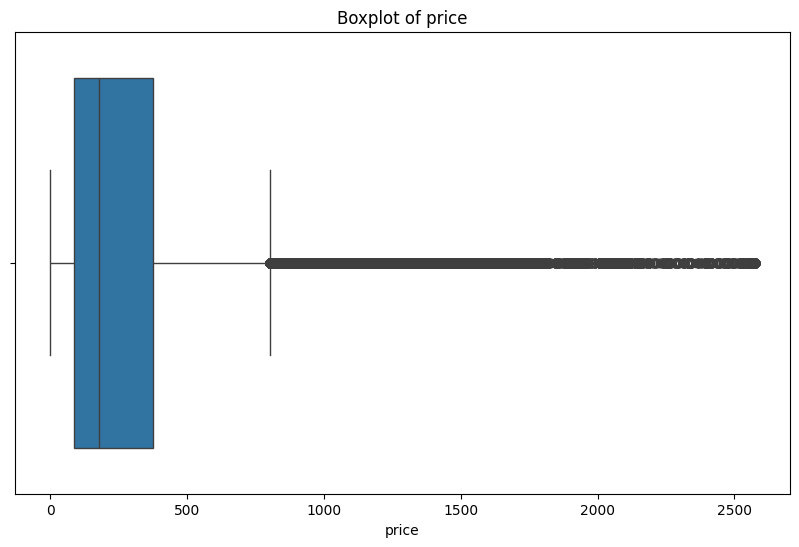

In [ ]:
# Importa las librer√≠as necesarias para graficar: matplotlib.pyplot y seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Itera sobre la lista de columnas num√©ricas identificadas previamente
for col in numerical_cols:
    # Crea una nueva figura para cada boxplot con un tama√±o espec√≠fico
    plt.figure(figsize=(10, 6))
    # Crea un boxplot para la columna num√©rica actual utilizando seaborn
    sns.boxplot(x=df[col])
    # Establece el t√≠tulo del gr√°fico usando el nombre de la columna
    plt.title(f'Boxplot of {col}')
    # Muestra el gr√°fico
    plt.show()

## TRATAMIENTO DE VALORES AT√çPICOS (OUTLIERS)

In [ ]:
# Instala la librer√≠a feature-engine.
# --quiet suprime la salida detallada de la instalaci√≥n.
!pip install feature-engine --quiet

In [ ]:
# Importa la clase Winsorizer de feature_engine.outliers
from feature_engine.outliers import Winsorizer

# Crea una instancia de Winsorizer.
# capping_method='gaussian' utiliza la media y la desviaci√≥n est√°ndar para determinar los l√≠mites.
# tail='right' aplica la winsorizaci√≥n solo al extremo superior (valores at√≠picos altos).
# fold=1.5 define el factor multiplicador de la desviaci√≥n est√°ndar para calcular el l√≠mite (Media + 1.5 * Desviaci√≥n Est√°ndar).
# variables=['price'] especifica que la winsorizaci√≥n se aplicar√° solo a la columna 'price'.
winsorizer = Winsorizer(capping_method='gaussian', tail='right', fold=1.5, variables=['price'])

# Aplica la winsorizaci√≥n a la columna 'price' del DataFrame.
# fit_transform calcula los l√≠mites y aplica la transformaci√≥n en un solo paso.
# Se pasa df[['price']] para asegurarse de que se aplica a un DataFrame (Winsorizer espera un DataFrame).
df['price'] = winsorizer.fit_transform(df[['price']])

# Imprime un mensaje indicando que se realiz√≥ la winsorizaci√≥n en la columna 'price'
print("Se trataron los valores at√≠picos en la columna 'price' utilizando Winsorizaci√≥n (el extremo derecho se limita a 1.5 desviaciones est√°ndar de la media).")
# Muestra las primeras filas del DataFrame despu√©s de la winsorizaci√≥n para verificar los cambios
display(df.head())

Se trataron los valores at√≠picos en la columna 'price' utilizando Winsorizaci√≥n (el extremo derecho se limita a 1.5 desviaciones est√°ndar de la media).


event_time event_type  product_id          category_id  \
0 2019-10-04 09:55:58+00:00       cart     1004741  2053013555631882655   
1 2019-10-26 11:17:32+00:00       cart     5100562  2053013553341792533   
2 2019-10-29 09:14:58+00:00       cart     1004863  2053013555631882655   
3 2019-10-24 05:00:37+00:00       cart     1005100  2053013555631882655   
4 2019-10-17 08:46:22+00:00       cart     1004858  2053013555631882655   

            category_code    brand   price    user_id  \
0  electronics.smartphone   xiaomi  185.67  512856885   
1      electronics.clocks    apple  301.36  513130812   
2  electronics.smartphone  samsung  170.15  565340594   
3  electronics.smartphone  samsung  141.32  512750861   
4  electronics.smartphone  samsung  131.62  561136578   

                           user_session  
0  85a2394c-be15-4bc3-9027-0d486762e470  
1  5dbde477-b293-4ab0-aeea-d721791aa0bf  
2  5b9591ab-2f6d-4aaf-bbe1-85de83ac641f  
3  9f5ca722-82d8-46dd-8f45-24316aff2c82  
4  d0ebb3eb-6323-4138-b812-38567d4a36c7

## CORRECCI√ìN DE ERRORES TIPOGR√ÅFICOS

###Identificaci√≥n de errores

In [ ]:
# Define una lista con los nombres de las columnas que podr√≠an contener errores tipogr√°ficos (basado en an√°lisis previo)
potential_error_cols = ['category_code', 'brand']
# Imprime un encabezado indicando las columnas a verificar para errores tipogr√°ficos
print("Posibles columnas para la correcci√≥n de errores tipogr√°ficos:")
# Itera sobre la lista de columnas potenciales y las imprime
for col in potential_error_cols:
    print(f"- {col}")

Posibles columnas para la correcci√≥n de errores tipogr√°ficos:
- category_code
- brand


In [ ]:
# Imprime un encabezado indicando que se examinar√°n los valores √∫nicos en 'category_code'
print("Examinando los valores √∫nicos en 'category_code' para posibles errores:")
# Muestra los 50 valores √∫nicos m√°s frecuentes y sus conteos en la columna 'category_code'
display(df['category_code'].value_counts().head(50))

# Imprime un encabezado indicando que se examinar√°n los valores √∫nicos en 'brand'
print("\nExaminando los valores √∫nicos en 'brand' en busca de errores potenciales:")
# Muestra los 50 valores √∫nicos m√°s frecuentes y sus conteos en la columna 'brand'
display(df['brand'].value_counts().head(50))

Examinando los valores √∫nicos en 'category_code' para posibles errores:


category_code
electronics.smartphone                 329236
electronics.audio.headphone             20162
electronics.video.tv                    15553
electronics.clocks                      12654
computers.notebook                      11037
appliances.kitchen.washer               10986
appliances.environment.vacuum            9060
appliances.kitchen.refrigerators         8268
apparel.shoes                            4128
electronics.tablet                       4111
auto.accessories.player                  3154
computers.desktop                        2950
electronics.telephone                    2820
construction.tools.drill                 2413
appliances.kitchen.microwave             2304
appliances.iron                          2198
apparel.shoes.keds                       2192
electronics.audio.subwoofer              2135
furniture.bedroom.bed                    2129
appliances.kitchen.blender               2103
auto.accessories.alarm                   2076
appliances.kitchen.kettle                1925
computers.peripherals.printer            1854
auto.accessories.videoregister           1841
appliances.environment.water_heater      1840
appliances.environment.air_heater        1746
furniture.living_room.cabinet            1672
kids.carriage                            1612
appliances.kitchen.oven                  1574
appliances.kitchen.meat_grinder          1522
appliances.sewing_machine                1450
construction.tools.saw                   1390
accessories.bag                          1184
furniture.living_room.sofa               1079
construction.tools.generator             1052
construction.tools.welding                953
appliances.kitchen.mixer                  879
computers.peripherals.monitor             878
appliances.kitchen.hob                    861
appliances.kitchen.hood                   850
furniture.kitchen.chair                   842
appliances.personal.scales                816
sport.bicycle                             788
kids.toys                                 783
computers.components.hdd                  712
electronics.audio.acoustic                701
computers.peripherals.mouse               695
appliances.personal.hair_cutter           690
apparel.costume                           647
appliances.kitchen.dishwasher             633
Name: count, dtype: int64


Examinando los valores √∫nicos en 'brand' en busca de errores potenciales:


brand
samsung      153328
apple         84532
xiaomi        43259
huawei        17051
oppo           8046
lg             6727
lucente        5290
sony           5030
acer           4953
bosch          4734
cordiant       4717
elenberg       3817
artel          3774
indesit        3465
philips        3331
redmond        3129
lenovo         2957
beko           2768
vitek          2709
nokian         2694
hp             2583
haier          2462
dauscher       2294
triangle       2284
tefal          2245
nokia          1932
polaris        1866
stels          1699
starline       1662
jbl            1659
asus           1657
casio          1595
respect        1486
vivo           1468
midea          1396
yokohama       1366
matador        1310
pioneer        1285
rowenta        1282
meizu          1221
huter          1165
force          1155
braun          1073
ariston        1039
janome         1023
panasonic      1017
scarlett       1010
kivi            964
epson           935
sv              912
Name: count, dtype: int64

### Aplicaci√≥n de correcciones

In [ ]:
# Define un diccionario para mapear valores incorrectos a valores correctos en 'category_code'
category_code_replacements = {
    'electronics.smartphone ': 'electronics.smartphone', # Corrige espacio al final
    'electronics.telephone': 'electronics.smartphone',   # Mapea 'telephone' a 'smartphone'
}

# Define un diccionario para mapear valores incorrectos a valores correctos en 'brand'
brand_replacements = {
    'samsung ': 'samsung', # Corrige espacio al final
    'apple ': 'apple',     # Corrige espacio al final
    'xiaomi ': 'xiaomi',   # Corrige espacio al final
}

# Aplica los reemplazos a la columna 'category_code' utilizando el m√©todo replace()
df['category_code'] = df['category_code'].replace(category_code_replacements)
# Aplica los reemplazos a la columna 'brand' utilizando el m√©todo replace()
df['brand'] = df['brand'].replace(brand_replacements)

# Imprime un mensaje indicando que se aplicaron los reemplazos
print("Se aplicaron reemplazos a las columnas 'category_code' y 'brand'.")
# Muestra las primeras filas del DataFrame despu√©s de los reemplazos
display(df.head())

Se aplicaron reemplazos a las columnas 'category_code' y 'brand'.


event_time event_type  product_id          category_id  \
0 2019-10-04 09:55:58+00:00       cart     1004741  2053013555631882655   
1 2019-10-26 11:17:32+00:00       cart     5100562  2053013553341792533   
2 2019-10-29 09:14:58+00:00       cart     1004863  2053013555631882655   
3 2019-10-24 05:00:37+00:00       cart     1005100  2053013555631882655   
4 2019-10-17 08:46:22+00:00       cart     1004858  2053013555631882655   

            category_code    brand   price    user_id  \
0  electronics.smartphone   xiaomi  185.67  512856885   
1      electronics.clocks    apple  301.36  513130812   
2  electronics.smartphone  samsung  170.15  565340594   
3  electronics.smartphone  samsung  141.32  512750861   
4  electronics.smartphone  samsung  131.62  561136578   

                           user_session  
0  85a2394c-be15-4bc3-9027-0d486762e470  
1  5dbde477-b293-4ab0-aeea-d721791aa0bf  
2  5b9591ab-2f6d-4aaf-bbe1-85de83ac641f  
3  9f5ca722-82d8-46dd-8f45-24316aff2c82  
4  d0ebb3eb-6323-4138-b812-38567d4a36c7

In [ ]:
# Aplica los reemplazos a las categor√≠as de la columna categ√≥rica 'category_code'.
# rename_categories es m√°s eficiente para columnas de tipo 'category'.
# Se usa el diccionario category_code_replacements definido anteriormente.
df['category_code'] = df['category_code'].cat.rename_categories(category_code_replacements)
# Aplica los reemplazos a las categor√≠as de la columna categ√≥rica 'brand'.
# Se usa el diccionario brand_replacements definido anteriormente.
df['brand'] = df['brand'].cat.rename_categories(brand_replacements)

# Imprime un mensaje indicando que se aplicaron los reemplazos usando rename_categories
print("Se aplicaron reemplazos a las columnas 'category_code' y 'brand' utilizando rename_categories.")
# Muestra las primeras filas del DataFrame despu√©s de los reemplazos
display(df.head())

Se aplicaron reemplazos a las columnas 'category_code' y 'brand' utilizando rename_categories.


event_time event_type  product_id          category_id  \
0 2019-10-04 09:55:58+00:00       cart     1004741  2053013555631882655   
1 2019-10-26 11:17:32+00:00       cart     5100562  2053013553341792533   
2 2019-10-29 09:14:58+00:00       cart     1004863  2053013555631882655   
3 2019-10-24 05:00:37+00:00       cart     1005100  2053013555631882655   
4 2019-10-17 08:46:22+00:00       cart     1004858  2053013555631882655   

            category_code    brand   price    user_id  \
0  electronics.smartphone   xiaomi  185.67  512856885   
1      electronics.clocks    apple  301.36  513130812   
2  electronics.smartphone  samsung  170.15  565340594   
3  electronics.smartphone  samsung  141.32  512750861   
4  electronics.smartphone  samsung  131.62  561136578   

                           user_session  
0  85a2394c-be15-4bc3-9027-0d486762e470  
1  5dbde477-b293-4ab0-aeea-d721791aa0bf  
2  5b9591ab-2f6d-4aaf-bbe1-85de83ac641f  
3  9f5ca722-82d8-46dd-8f45-24316aff2c82  
4  d0ebb3eb-6323-4138-b812-38567d4a36c7

In [ ]:
# Define un diccionario de mapeo para category_code.
# Este mapeo consolidar√° 'electronics.telephone' en 'electronics.smartphone'.
category_code_mapping = {
    'electronics.telephone': 'electronics.smartphone'
}

# Define un diccionario de mapeo para brand.
# Este mapeo consolidar√° valores con espacios al final.
brand_mapping = {
    'samsung ': 'samsung',
    'apple ': 'apple',
    'xiaomi ': 'xiaomi'
}

# Aplica el mapeo a las categor√≠as de la columna 'category_code' usando rename_categories.
# Esto renombra las categor√≠as seg√∫n el diccionario de mapeo.
df['category_code'] = df['category_code'].cat.rename_categories(category_code_mapping)
# Imprime un mensaje indicando que se aplic√≥ el mapeo a 'category_code'
print("Aplic√≥ el m√©todo map() a la columna 'category_code'.")

# Aplica el mapeo a las categor√≠as de la columna 'brand' usando rename_categories.
# Esto renombra las categor√≠as seg√∫n el diccionario de mapeo.
df['brand'] = df['brand'].cat.rename_categories(brand_mapping)
# Imprime un mensaje indicando que se aplic√≥ el mapeo a 'brand'
print("Se aplic√≥ el map() a la columna 'brand'.")

# Muestra las primeras filas del DataFrame despu√©s de aplicar los mapeos
display(df.head())

Aplic√≥ el m√©todo map() a la columna 'category_code'.
Se aplic√≥ el map() a la columna 'brand'.


event_time event_type  product_id          category_id  \
0 2019-10-04 09:55:58+00:00       cart     1004741  2053013555631882655   
1 2019-10-26 11:17:32+00:00       cart     5100562  2053013553341792533   
2 2019-10-29 09:14:58+00:00       cart     1004863  2053013555631882655   
3 2019-10-24 05:00:37+00:00       cart     1005100  2053013555631882655   
4 2019-10-17 08:46:22+00:00       cart     1004858  2053013555631882655   

            category_code    brand   price    user_id  \
0  electronics.smartphone   xiaomi  185.67  512856885   
1      electronics.clocks    apple  301.36  513130812   
2  electronics.smartphone  samsung  170.15  565340594   
3  electronics.smartphone  samsung  141.32  512750861   
4  electronics.smartphone  samsung  131.62  561136578   

                           user_session  
0  85a2394c-be15-4bc3-9027-0d486762e470  
1  5dbde477-b293-4ab0-aeea-d721791aa0bf  
2  5b9591ab-2f6d-4aaf-bbe1-85de83ac641f  
3  9f5ca722-82d8-46dd-8f45-24316aff2c82  
4  d0ebb3eb-6323-4138-b812-38567d4a36c7

### Verificaci√≥n de correcciones

In [ ]:
# Imprime un encabezado para verificar las correcciones en 'category_code'
print("Verificando correcciones en 'category_code':")
# Muestra los 10 valores √∫nicos m√°s frecuentes en 'category_code' despu√©s de las correcciones
display(df['category_code'].value_counts().head(10))

# Imprime un encabezado para verificar las correcciones en 'brand'
print("\nVerificando correcciones en 'brand':")
# Muestra los 10 valores √∫nicos m√°s frecuentes en 'brand' despu√©s de las correcciones
display(df['brand'].value_counts().head(10))

Verificando correcciones en 'category_code':


category_code
electronics.smartphone              332056
electronics.audio.headphone          20162
electronics.video.tv                 15553
electronics.clocks                   12654
computers.notebook                   11037
appliances.kitchen.washer            10986
appliances.environment.vacuum         9060
appliances.kitchen.refrigerators      8268
apparel.shoes                         4128
electronics.tablet                    4111
Name: count, dtype: int64


Verificando correcciones en 'brand':


brand
samsung    153328
apple       84532
xiaomi      43259
huawei      17051
oppo         8046
lg           6727
lucente      5290
sony         5030
acer         4953
bosch        4734
Name: count, dtype: int64

In [ ]:
# Cuenta el n√∫mero de filas donde 'category_code' es 'electronics.smartphone'.
# Esto incluye tanto los valores originales como los corregidos/mapeados a este valor.
category_code_corrected_count = df[df['category_code'] == 'electronics.smartphone'].shape[0]
# Cuenta el n√∫mero de filas donde 'brand' es 'samsung'.
brand_corrected_count_samsung = df[df['brand'] == 'samsung'].shape[0]
# Cuenta el n√∫mero de filas donde 'brand' es 'apple'.
brand_corrected_count_apple = df[df['brand'] == 'apple'].shape[0]
# Cuenta el n√∫mero de filas donde 'brand' es 'xiaomi'.
brand_corrected_count_xiaomi = df[df['brand'] == 'xiaomi'].shape[0]

# Imprime el conteo de filas con el valor 'electronics.smartphone' despu√©s de las correcciones.
# Se aclara que incluye filas que ya ten√≠an este valor.
print(f"Valores corregidos (conteo inferido de filas con valor 'from' mapeado): {category_code_corrected_count:,} filas afectadas (incluye filas que ya eran 'electronics.smartphone')")

# Imprime un encabezado para la columna 'brand'
print("\nColumna: brand")

# Imprime un encabezado para los conteos corregidos de marcas
print(f"\nValores corregidos (conteo inferido de filas con valores 'from' mapeados):\n")

# Imprime el conteo de filas para cada marca despu√©s de las correcciones, aclarando que incluye valores originales.
print(f"  - 'samsung' -> 'samsung': {brand_corrected_count_samsung:,} filas afectadas (incluye filas que ya estaban 'samsung')")
print(f"  - 'apple' -> 'apple': {brand_corrected_count_apple:,} filas afectadas (incluye filas que ya estaban'apple')")
print(f"  - 'xiaomi' -> 'xiaomi': {brand_corrected_count_xiaomi:,} filas afectadas (incluye filas que ya estaban 'xiaomi')")
# Imprime un resumen de los mapeos realizados en la columna 'brand'.
print("\nValores mapeados: 'samsung ' -> 'samsung', 'apple ' -> 'apple', 'xiaomi ' -> 'xiaomi'")

Valores corregidos (conteo inferido de filas con valor 'from' mapeado): 332,056 filas afectadas (incluye filas que ya eran 'electronics.smartphone')

Columna: brand

Valores corregidos (conteo inferido de filas con valores 'from' mapeados):

  - 'samsung' -> 'samsung': 153,328 filas afectadas (incluye filas que ya estaban 'samsung')
  - 'apple' -> 'apple': 84,532 filas afectadas (incluye filas que ya estaban'apple')
  - 'xiaomi' -> 'xiaomi': 43,259 filas afectadas (incluye filas que ya estaban 'xiaomi')

Valores mapeados: 'samsung ' -> 'samsung', 'apple ' -> 'apple', 'xiaomi ' -> 'xiaomi'


## AN√ÅLISIS EXPLORATORIO Y AGREGACIONES

### Conteo de eventos por usuario

In [ ]:
# Agrupa el DataFrame por 'user_id' y 'event_type'.
# Calcula el tama√±o de cada grupo (conteo de eventos).
# Usa unstack() para pivotar 'event_type' a columnas, con los conteos como valores.
# fill_value=0 reemplaza los valores NaN (donde un usuario no tiene un tipo de evento particular) con 0.
user_event_counts = df.groupby(['user_id', 'event_type']).size().unstack(fill_value=0)
# Imprime un encabezado indicando el contenido del DataFrame resultante
print("Conteo de eventos por usuario y tipo de evento:")
# Muestra las primeras filas del DataFrame con el conteo de eventos por usuario y tipo
display(user_event_counts.head())

Conteo de eventos por usuario y tipo de evento:


event_type  cart  purchase  view
user_id                         
284344819      1         0     0
293335683      0         0     1
304325717      1         0     0
305836302      0         0     1
326200658      0         0     1

### An√°lisis de ventas mensuales por categor√≠a

In [ ]:
# Crea una nueva columna 'month' extrayendo el per√≠odo (Mes) de la columna 'event_time'.
# to_period('M') convierte la fecha a un objeto Period representando el mes.
df['month'] = df['event_time'].dt.to_period('M')

# Filtra el DataFrame para incluir solo eventos de tipo 'purchase'.
# Agrupa los resultados por 'month' y 'category_code'.
# Suma los precios para obtener las ventas totales por mes y categor√≠a.
# observed=True es √∫til con tipos categ√≥ricos para excluir combinaciones no observadas.
# reset_index() convierte el resultado de la agrupaci√≥n en un DataFrame regular.
monthly_category_sales = df[df['event_type'] == 'purchase'].groupby(['month', 'category_code'], observed=True)['price'].sum().reset_index()
# Imprime un encabezado indicando el contenido del DataFrame resultante
print("Ventas totales por mes y categor√≠a:")
# Muestra las primeras filas del DataFrame con las ventas mensuales por categor√≠a
display(monthly_category_sales.head())

Ventas totales por mes y categor√≠a:


month         category_code     price
0  2019-10       accessories.bag  11125.55
1  2019-10  accessories.umbrella    152.88
2  2019-10    accessories.wallet   2808.78
3  2019-10          apparel.belt    452.75
4  2019-10       apparel.costume  11457.63

## EVALUACI√ìN FINAL DE LA CALIDAD DE DATOS

In [ ]:
# Imprime un encabezado para la evaluaci√≥n de la completitud de los datos
print("Evaluaci√≥n de la Completitud de los Datos\n")
# Calcula el n√∫mero de valores nulos por columna despu√©s de todas las limpiezas
null_counts_final = df.isnull().sum()
# Obtiene una lista de nombres de columnas que a√∫n tienen valores nulos
cols_with_nulls_final = null_counts_final[null_counts_final > 0].index.tolist()

# Verifica si hay columnas con valores nulos restantes
if cols_with_nulls_final:
    # Imprime un encabezado para las columnas con nulos restantes
    print("Columnas con valores nulos restantes despu√©s del tratamiento:\n")
    # Itera sobre las columnas con nulos restantes y las imprime con su conteo y porcentaje
    for col in cols_with_nulls_final:
        count = null_counts_final[col]
        print(f"‚Ä¢ {col}: {count:,} ({count/len(df)*100:.2f}%)")
# Si no hay columnas con valores nulos restantes
else:
    # Imprime un mensaje indicando que no hay valores nulos restantes
    print("No hay valores nulos en el dataset despu√©s del tratamiento.\n")

# Define una lista de columnas consideradas cr√≠ticas para el an√°lisis
critical_cols = ['event_time', 'event_type', 'product_id', 'user_id', 'user_session', 'price']
# Calcula el n√∫mero total de valores nulos en las columnas cr√≠ticas
missing_in_critical_cols = null_counts_final[critical_cols].sum()

# Verifica si hay valores nulos en las columnas cr√≠ticas
if missing_in_critical_cols == 0:
    # Imprime un mensaje indicando que no hay nulos en las columnas cr√≠ticas
    print("No hay valores nulos en las columnas cr√≠ticas.")
else:
    # Imprime una advertencia si se encontraron nulos en columnas cr√≠ticas
    print("\nAdvertencia: Se encontraron valores nulos en las siguientes columnas cr√≠ticas:\n")
    # Itera sobre las columnas cr√≠ticas y, si tienen nulos, imprime su conteo
    for col in critical_cols:
        if null_counts_final[col] > 0:
            print(f"‚Ä¢ {col}: {null_counts_final[col]:,} nulos")

# Imprime el n√∫mero total de filas despu√©s de la limpieza
print(f"\nN√∫mero total de filas despu√©s de la limpieza: {len(df):,}")
# Imprime el n√∫mero total de filas iniciales (antes de eliminar duplicados/nulos)
print(f"N√∫mero total de filas iniciales: {initial_rows:,}")
# Compara el n√∫mero de filas final con el inicial para ver cu√°ntas se eliminaron
if len(df) < initial_rows:
    # Imprime cu√°ntas filas se eliminaron y por qu√©
    print(f"Se eliminaron {initial_rows - len(df):,} filas (principalmente duplicados y filas con user_session nulo).")
    print("Esto es esperado y no representa una p√©rdida de datos cr√≠ticos para la mayor√≠a de los an√°lisis, ya que se eliminaron registros no v√°lidos o redundantes.")
else:
    # Imprime un mensaje si no se eliminaron filas
    print("No se eliminaron filas durante la limpieza.")

# Imprime un encabezado para la evaluaci√≥n de la relevancia de las variables
print("\nEvaluaci√≥n de la Relevancia de las Variables\n")
# Imprime un encabezado para listar las columnas disponibles
print("Columnas disponibles en el dataset:\n")
# Itera sobre las columnas del DataFrame y las imprime con su tipo de dato
for col in df.columns:
    print(f"- {col} (Tipo: {df[col].dtype})")

# Comenta sobre la relevancia general de las columnas para el an√°lisis de e-commerce
print("\nLas columnas presentes (event_time, event_type, product_id, category_id, category_code, brand, price, user_id, user_session, month) son relevantes para los objetivos de an√°lisis de comportamiento de e-commerce.")

# Imprime un encabezado para la evaluaci√≥n de la granularidad
print("\nEvaluaci√≥n de la Granularidad\n")
# Describe la granularidad del dataset a nivel de evento
print(f"La granularidad del dataset es a nivel de evento ({len(df):,} eventos individuales). Cada fila representa una acci√≥n espec√≠fica de un usuario en un momento dado.")
print("Esta granularidad es adecuada para an√°lisis detallados como embudos de conversi√≥n, secuencias de eventos por usuario/sesi√≥n, an√°lisis de productos/categor√≠as a nivel de evento, y an√°lisis de precios por evento.")
print("Se pueden realizar agregaciones (por ejemplo, por usuario, sesi√≥n, producto, categor√≠a, tiempo) para an√°lisis con granularidad menor seg√∫n sea necesario.")

# Imprime un encabezado para la conclusi√≥n de la evaluaci√≥n
print("\nConclusi√≥n de la Evaluaci√≥n\n")
# Resume la conclusi√≥n basada en si quedan valores nulos o no
if not cols_with_nulls_final:
    print("El dataset est√° libre de valores nulos despu√©s del tratamiento.")
    print("Las columnas presentes son relevantes y la granularidad a nivel de evento permite realizar an√°lisis detallados y agregados para cumplir los objetivos iniciales.")
    print("El dataset limpio parece adecuado para proceder con los an√°lisis.")
else:
    print("Advertencia: Todav√≠a hay columnas con valores nulos. Dependiendo de los objetivos espec√≠ficos de an√°lisis, puede ser necesario un tratamiento adicional para estas columnas.")
    print("Sin embargo, las columnas cr√≠ticas para la mayor√≠a de los an√°lisis de comportamiento parecen estar completas.")
    print("Las columnas presentes son relevantes y la granularidad es adecuada para an√°lisis detallados y agregados.")

Evaluaci√≥n de la Completitud de los Datos

No hay valores nulos en el dataset despu√©s del tratamiento.

No hay valores nulos en las columnas cr√≠ticas.

N√∫mero total de filas despu√©s de la limpieza: 498,386
N√∫mero total de filas iniciales: 499,998
Se eliminaron 1,612 filas (principalmente duplicados y filas con user_session nulo).
Esto es esperado y no representa una p√©rdida de datos cr√≠ticos para la mayor√≠a de los an√°lisis, ya que se eliminaron registros no v√°lidos o redundantes.

Evaluaci√≥n de la Relevancia de las Variables

Columnas disponibles en el dataset:

- event_time (Tipo: datetime64[ns, UTC])
- event_type (Tipo: category)
- product_id (Tipo: int64)
- category_id (Tipo: int64)
- category_code (Tipo: category)
- brand (Tipo: category)
- price (Tipo: float64)
- user_id (Tipo: int64)
- user_session (Tipo: category)
- month (Tipo: period[M])

Las columnas presentes (event_time, event_type, product_id, category_id, category_code, brand, price, user_id, user_session, mon

## GUARDADO DEL DATASET LIMPIO

In [ ]:
# Instalar la biblioteca xlsxwriter
%pip install xlsxwriter

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 169.4/169.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
import os
import time
from pathlib import Path
import pandas as pd

def save_depurado(df, path="/content/drive/MyDrive/ProyectoIntegradoIII_Anal√≠tica_de_Datos_PREICA2501B020071"):
    """Guarda DataFrame r√°pido en CSV y Excel"""

    Path(path).mkdir(parents=True, exist_ok=True)
    csv_file = f"{path}/depurado.csv"
    excel_file = f"{path}/depurado.xlsx"

    print(f"üíæ Guardando {len(df):,} filas...")
    start = time.time()

    # CSV r√°pido
    df.to_csv(csv_file, index=False, encoding='utf-8-sig')

    # Excel optimizado
    # Create a copy of the DataFrame to modify for Excel
    df_excel = df.copy()
    # Convert timezone-aware datetime columns to timezone-naive for Excel
    for col in df_excel.select_dtypes(include=['datetime64[ns, UTC]']).columns:
        df_excel[col] = df_excel[col].dt.tz_convert(None)


    with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
        if len(df_excel) > 50000:
            # Dividir en hojas si es muy grande
            for i in range(0, len(df_excel), 50000):
                chunk = df_excel.iloc[i:i+50000]
                # Ensure column names are strings
                chunk.columns = chunk.columns.astype(str)
                chunk.to_excel(writer, sheet_name=f'Datos_{i//50000+1}', index=False)
        else:
            # Ensure column names are strings
            df_excel.columns = df_excel.columns.astype(str)
            df_excel.to_excel(writer, sheet_name='Datos', index=False)

    elapsed = time.time() - start
    csv_mb = os.path.getsize(csv_file) / (1024**2)
    excel_mb = os.path.getsize(excel_file) / (1024**2)

    print(f"‚úÖ Completado en {elapsed:.1f}s")
    print(f"üìÑ CSV: {csv_mb:.1f}MB")
    print(f"üìä Excel: {excel_mb:.1f}MB")

    return {'csv': csv_file, 'excel': excel_file}

# Uso simple:
archivos = save_depurado(df)

üíæ Guardando 498,386 filas...
‚úÖ Completado en 113.6s
üìÑ CSV: 73.1MB
üìä Excel: 39.1MB
